# Forecasting with a stateful RNN

## Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

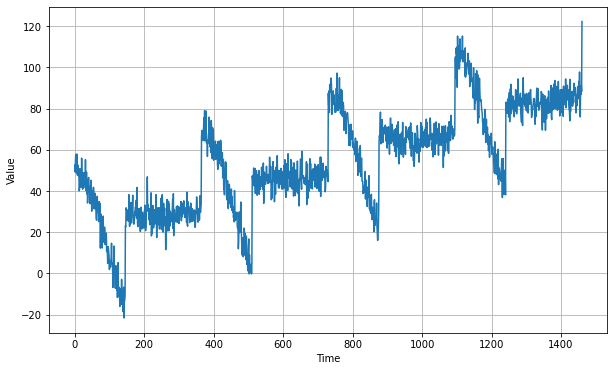

In [8]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [9]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Stateful RNN Forecasting

In [10]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)  # next window
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))          # note no shuffle is used bc we want it ordered
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [11]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [12]:
class ResetStatesCallback(keras.callbacks.Callback):   # reset the state of the batch window
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),           # here you need batch size which is 1 and time steps and input dimention which is 1 b/c univariate
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)   # for stabalization can be done by normalization.
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()                # resets the state of the batch window
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])  # calls reset

Epoch 1/100
33/33 [==============================] - 4s 134ms/step - loss: 105.9339 - mae: 106.4339
Epoch 2/100
33/33 [==============================] - 1s 26ms/step - loss: 72.1532 - mae: 71.3570: 0s - loss: 73.5771 - mae: 74.077
Epoch 3/100
33/33 [==============================] - 1s 28ms/step - loss: 40.7396 - mae: 40.3047
Epoch 4/100
33/33 [==============================] - 1s 26ms/step - loss: 27.6155 - mae: 27.8404
Epoch 5/100
33/33 [==============================] - 1s 25ms/step - loss: 24.7553 - mae: 24.9891
Epoch 6/100
33/33 [==============================] - 1s 30ms/step - loss: 23.5799 - mae: 23.7517
Epoch 7/100
33/33 [==============================] - 1s 34ms/step - loss: 22.4292 - mae: 22.5533
Epoch 8/100
33/33 [==============================] - 1s 25ms/step - loss: 21.2604 - mae: 21.3463: 0s - loss: 23.7198 - mae: 24.2
Epoch 9/100
33/33 [==============================] - 1s 25ms/step - loss: 20.2542 - mae: 20.3245
Epoch 10/100
33/33 [==============================] - 1s 2

33/33 [==============================] - 1s 21ms/step - loss: 30.5254 - mae: 30.4955
Epoch 82/100
33/33 [==============================] - 1s 23ms/step - loss: 32.1596 - mae: 31.9796
Epoch 83/100
33/33 [==============================] - 1s 23ms/step - loss: 33.0922 - mae: 33.5606
Epoch 84/100
33/33 [==============================] - 1s 21ms/step - loss: 24.5647 - mae: 25.4306
Epoch 85/100
33/33 [==============================] - 1s 22ms/step - loss: 14.6224 - mae: 15.4663
Epoch 86/100
33/33 [==============================] - 1s 21ms/step - loss: 29.3608 - mae: 29.1574
Epoch 87/100
33/33 [==============================] - 1s 21ms/step - loss: 25.1250 - mae: 25.4012
Epoch 88/100
33/33 [==============================] - 1s 23ms/step - loss: 16.7685 - mae: 17.1101
Epoch 89/100
33/33 [==============================] - 1s 22ms/step - loss: 30.8879 - mae: 30.7152: 0s - loss: 37.1687 - mae: 37
Epoch 90/100
33/33 [==============================] - 1s 21ms/step - loss: 33.2769 - mae: 32.9252
Epo

(1e-08, 0.0001, 0.0, 30.0)

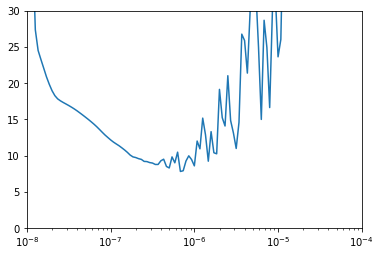

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,       # statefull is true here
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])   # note three calls here.

Epoch 1/500
33/33 [==============================] - 5s 148ms/step - loss: 60.2497 - mae: 60.7476 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00
Epoch 2/500
33/33 [==============================] - 1s 26ms/step - loss: 25.2905 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 1s 26ms/step - loss: 21.8154 - mae: 19.2167 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 1s 35ms/step - loss: 20.4004 - mae: 18.0143 - val_loss: 10.4489 - val_mae: 10.9392
Epoch 5/500
33/33 [==============================] - 1s 38ms/step - loss: 19.5472 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4500
Epoch 6/500
33/33 [==============================] - 1s 32ms/step - loss: 18.6853 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 1s 32ms/step - loss: 17.9377 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [===========================

33/33 [==============================] - 1s 26ms/step - loss: 8.7470 - mae: 8.0485 - val_loss: 7.2325 - val_mae: 7.7193
Epoch 63/500
33/33 [==============================] - 1s 25ms/step - loss: 8.6982 - mae: 8.0126 - val_loss: 7.2253 - val_mae: 7.7120
Epoch 64/500
33/33 [==============================] - 1s 25ms/step - loss: 8.6512 - mae: 7.9792 - val_loss: 7.2331 - val_mae: 7.7198
Epoch 65/500
33/33 [==============================] - 1s 26ms/step - loss: 8.6072 - mae: 7.9491 - val_loss: 7.2639 - val_mae: 7.7507
Epoch 66/500
33/33 [==============================] - 1s 25ms/step - loss: 8.5653 - mae: 7.9210 - val_loss: 7.3072 - val_mae: 7.7942
Epoch 67/500
33/33 [==============================] - 1s 25ms/step - loss: 8.5229 - mae: 7.8922 - val_loss: 7.3386 - val_mae: 7.8257
Epoch 68/500
33/33 [==============================] - 1s 25ms/step - loss: 8.4771 - mae: 7.8593 - val_loss: 7.3363 - val_mae: 7.8234
Epoch 69/500
33/33 [==============================] - 1s 25ms/step - loss: 8.4285 

In [17]:
model = keras.models.load_model("my_checkpoint.h5")

In [18]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])   # 3 dimention here 
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

In [19]:
rnn_forecast.shape

(461,)

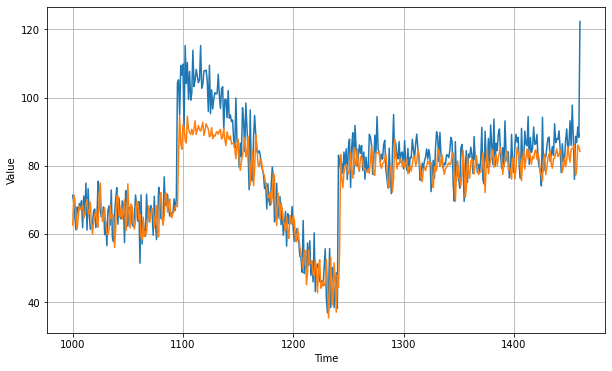

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.277834